In [7]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [8]:
data_path = './data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


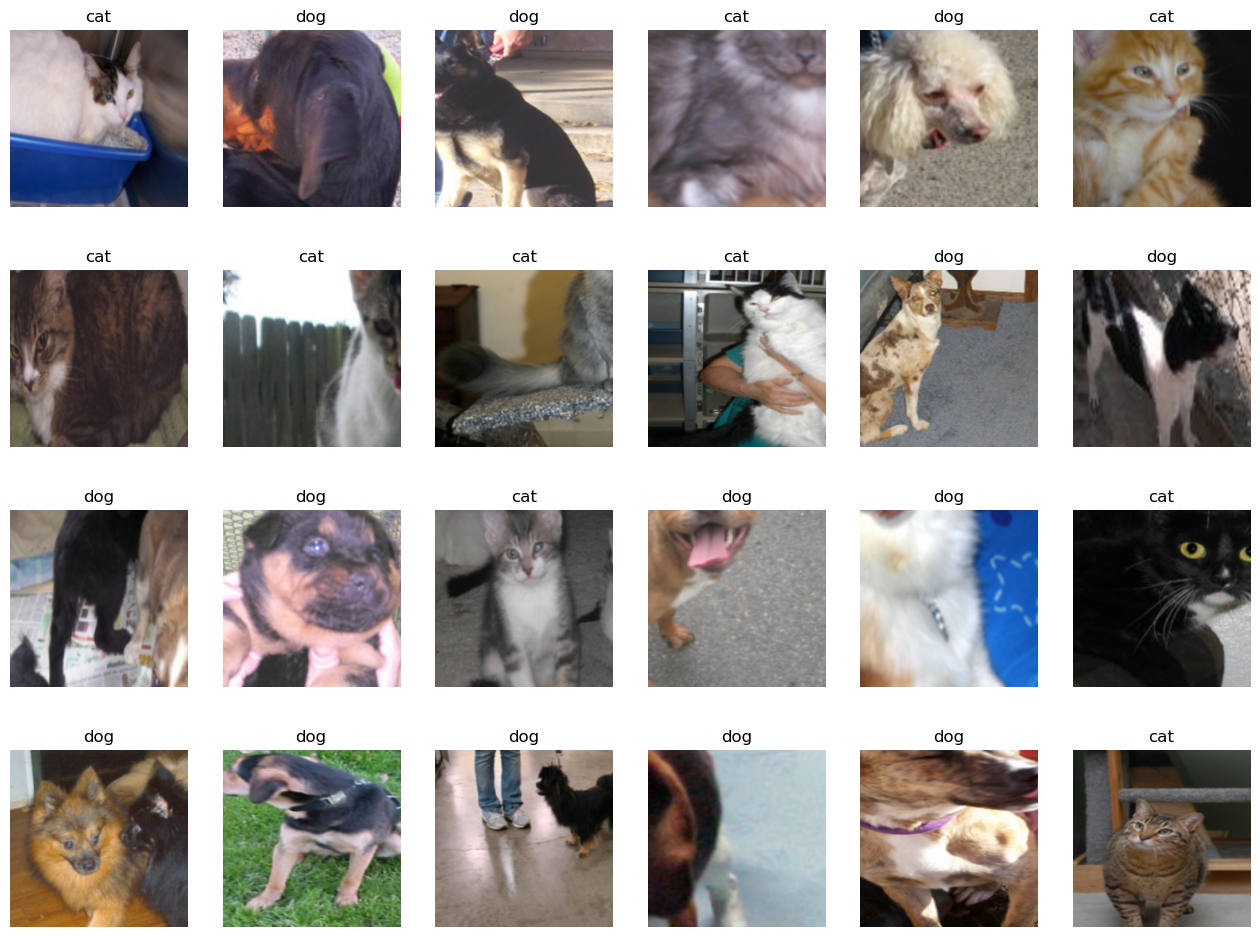

In [9]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [10]:
resnet18 = models.resnet18(pretrained=True)

/Users/min/anaconda3/envs/torch_practice/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Users/min/anaconda3/envs/torch_practice/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/min/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [11]:
def set_parameter_required_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_required_grad(resnet18)

In [12]:
resnet18.fc = nn.Linear(512, 2)

In [13]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0392,  0.0026,  0.0103,  ...,  0.0147, -0.0364,  0.0383],
        [-0.0172,  0.0050, -0.0104,  ...,  0.0422, -0.0428,  0.0102]])
fc.bias tensor([-0.0201, -0.0255])


In [14]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/min/anaconda3/envs/torch_practice/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Users/min/anaconda3/envs/torch_practice/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_trian=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()
    time_elapsed = time.time()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [19]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.1995 Acc: 0.9325

Epoch 1/12
----------
Loss: 0.2405 Acc: 0.8935

Epoch 2/12
----------
Loss: 0.1774 Acc: 0.9325

Epoch 3/12
----------
Loss: 0.2484 Acc: 0.9013

Epoch 4/12
----------
Loss: 0.2625 Acc: 0.8753

Epoch 5/12
----------
Loss: 0.2813 Acc: 0.8909

Epoch 6/12
----------
Loss: 0.1987 Acc: 0.9117

Epoch 7/12
----------
Loss: 0.2408 Acc: 0.8961

Epoch 8/12
----------
Loss: 0.1605 Acc: 0.9299

Epoch 9/12
----------
Loss: 0.2052 Acc: 0.8909

Epoch 10/12
----------
Loss: 0.1573 Acc: 0.9325

Epoch 11/12
----------
Loss: 0.1998 Acc: 0.9169

Epoch 12/12
----------
Loss: 0.1619 Acc: 0.9351

Training complete in 28116302m 19s
Best Acc: 0.935065


In [21]:
test_path = './data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [22]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()
    
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [23]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog/00.pth', './data/catanddog/01.pth', './data/catanddog/02.pth', './data/catanddog/03.pth', './data/catanddog/04.pth', './data/catanddog/05.pth', './data/catanddog/06.pth', './data/catanddog/07.pth', './data/catanddog/08.pth', './data/catanddog/09.pth', './data/catanddog/10.pth', './data/catanddog/11.pth', './data/catanddog/12.pth']
Loading model ./data/catanddog/00.pth
Acc: 0.9184

Loading model ./data/catanddog/01.pth
Acc: 0.9490

Loading model ./data/catanddog/02.pth
Acc: 0.9286

Loading model ./data/catanddog/03.pth
Acc: 0.9490

Loading model ./data/catanddog/04.pth
Acc: 0.9184

Loading model ./data/catanddog/05.pth
Acc: 0.9592

Loading model ./data/catanddog/06.pth
Acc: 0.8980

Loading model ./data/catanddog/07.pth
Acc: 0.9490

Loading model ./data/catanddog/08.pth
Acc: 0.9184

Loading model ./data/catanddog/09.pth
Acc: 0.9388

Loading model ./data/catanddog/10.pth
Acc: 0.9388

Loading model ./data/catanddog/11.pth
Acc: 0.9490

Loading model ./data/cat

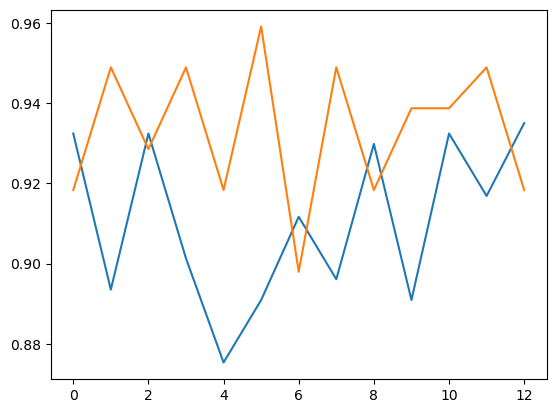

In [25]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

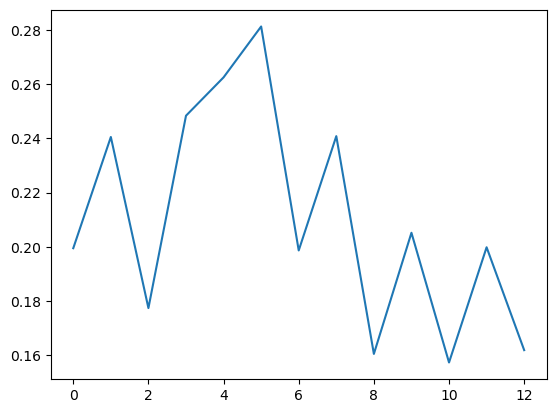

In [26]:
plt.plot(train_loss_hist)
plt.show()

In [32]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5,0.5,0.5))) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image

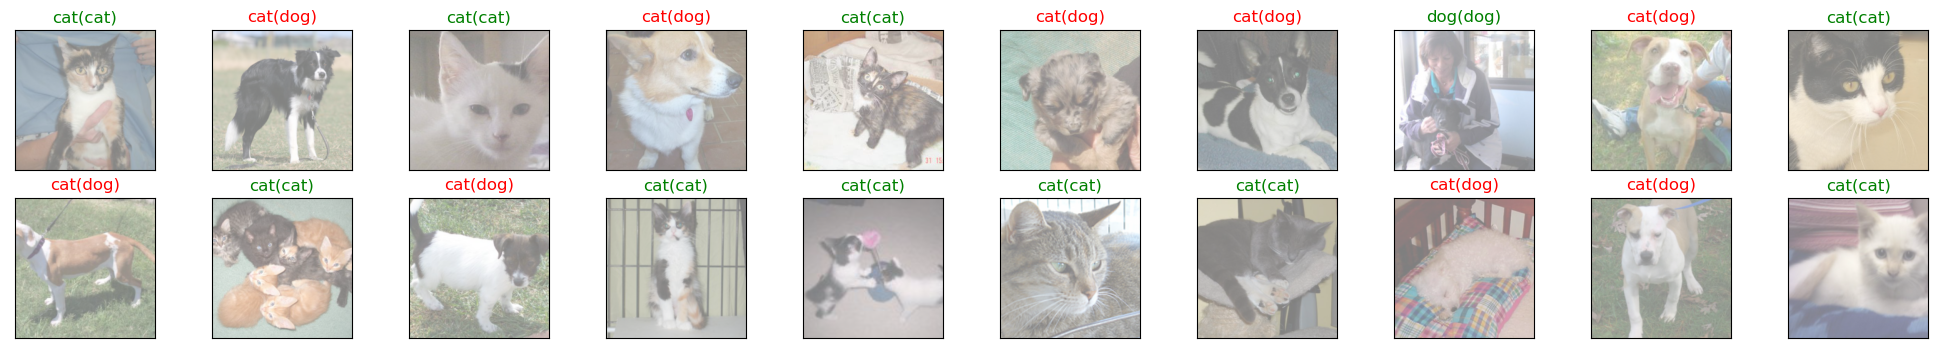

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)